![Logo 01](https://staff.utia.cas.cz/novozada/dizo/DIZO004_F.png)



**Course website:** [http://zoi.utia.cas.cz/NPGR032](http://zoi.utia.cas.cz/NPGR032)


# Part 0: Imports Packages & Data & Helper Functions

In [ ]:
import requests
import zipfile
import os
import errno
import cv2 as cv
# For showing the images in Colab use wrap function cv2_imshow
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import time
import glob
import itertools
import os
from IPython import display
import math
import scipy
import warnings
warnings.filterwarnings("ignore")

filename = 'DIZO004_data.zip'
url = f'http://staff.utia.cas.cz/novozada/dizo/{filename}'
try:
    os.mkdir(f'{filename[:-4]}')
    r = requests.get(url, allow_redirects=True)
    open(filename, 'wb').write(r.content)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall("")
except OSError as e:
    if e.errno != errno.EEXIST:
        raise
    else:
        print(f'{filename[:-4]} folder already exists!')

def resize(img, height=200, interpolation=cv.INTER_CUBIC):
  scale = height / img.shape[0]
  width = int(img.shape[1] * scale)
  new_size = (width, height)
  return cv.resize(img, new_size, interpolation = interpolation)

def show(img, height=200, interpolation=cv.INTER_CUBIC):
  img_new = resize(img, height, interpolation = interpolation)
  cv2_imshow(img_new)

# def show_list(imgs, height=100):
#   img_new = resize(imgs[0].astype(float), height)
#   img_new = cv.normalize(img_new, None, 0, 255, cv.NORM_MINMAX)
#   if len(imgs) > 1:
#     for img in imgs[1:]:
#       img_ = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)
#       img_new = cv.hconcat([img_new, resize(img_, height).astype(float)])
#   cv2_imshow(img_new)

def show_list(height, *imgs):
    show_more(height, *[cv.normalize(img, None, 0, 255, cv.NORM_MINMAX) for img in imgs])

def show_more(height, *imgs):
    img_new = cv.hconcat([resize(img, height).astype(float) for img in imgs])
    cv2_imshow(img_new)

def getFilenames(exts):
    fnames = [glob.glob(ext) for ext in exts]
    fnames = list(itertools.chain.from_iterable(fnames))
    fnames.sort()
    return fnames

# Part 1: Hough Transform

**What is the Hough transform and what is it used for?:**
-  a method for finding a parametric description of objects in an image
-  originally for detecting simple objects in an image such as lines, circles, ellipses, etc.
-  it is mainly used to segment objects whose boundaries can be described by simple curves
-  application also in 3D vision

<img src="https://staff.utia.cas.cz/novozada/dizo/htdemo.png">


**Presentation about HT:**
[Everything you were afraid to ask about Hough Transform :)](https://staff.utia.cas.cz/novozada/dizo/HoughTransformPrezentace.pdf)


### Line parameterization:
Do not use thist line parameterization:
$
\begin{aligned}
y &= a x  + b
\end{aligned}
$

- It causes problems with vertical lines.

Duda and Hart [1971] proposed the use of the Hesse normal form:
$$
\begin{align}\Large
r = \color{purple}{x \, \cos \, \theta} + \color{orange}{y \, \sin \, \theta}
\end{align}
$$
where $r$ is the distance from the origin to the closest point on the straight line, and $\theta$  is the angle between the $x$ axis and the line connecting the origin with that closest point.

<br />
<img src="https://staff.utia.cas.cz/novozada/dizo/line0.png">

Hence, each straight line in the image can be represented as a point ($\theta$, $r$) in the parameter space.

<img src="https://staff.utia.cas.cz/novozada/dizo/ht04.jpg">



## Hough transform from the scratch

Read the image **chessboard.png** and do these steps:


1.   resize it to 256px in height
2.   convert it to grayscale
3.   detect its edges

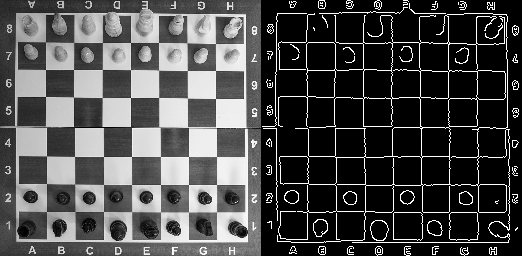

In [ ]:
img = cv.imread('chessboard.png')
img = resize(img, 256)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
canny = cv.Canny(gray, 400, 600)
show_more(256, gray, canny)

Write the Hough transform

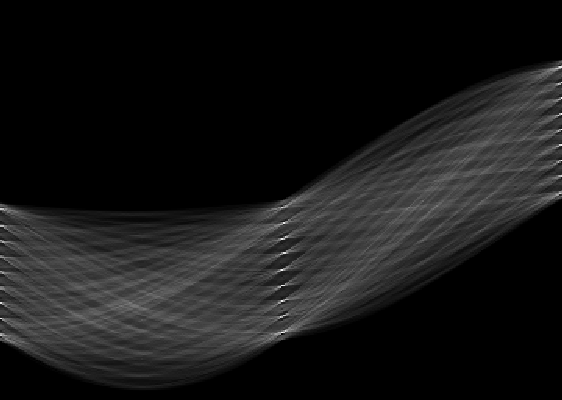

In [ ]:
def hough(img, dists=200, thetas=180):
  hits = np.zeros((dists, thetas))
  # size of one pixel in real distances
  pix2dists = dists / np.linalg.norm(img.shape) / 2
  # passing all pixels of the image
  for y in range(img.shape[0]):
    for x in range(img.shape[1]):
      # we only want non-zero points
      if img[y, x] > 0:
        # we calculate the distance from the origin
        # for all directions of lines passing through the point
        for idx_theta in range(thetas):
          # the angle in radians
          theta = idx_theta / thetas   * np.pi
          # distance of the line from the origin in pixels
          r = x * np.cos(theta) + y * np.sin(theta)
          # distance rescaled to lengths
          idx_r = int(np.round(r * pix2dists + (dists - 1) / 2))
          # the point with angle theta has another hit for distance r
          hits[idx_r,idx_theta] += 1
  return hits

ht = hough(canny,256,360)
show(ht, 400, interpolation=cv.INTER_NEAREST)

Use the HT to find lines in the image

$$
\begin{align}
r & = x \cos\theta + y\sin\theta \\
y & = \frac{r - x \cos\theta}{\sin\theta }
\end{align}
$$

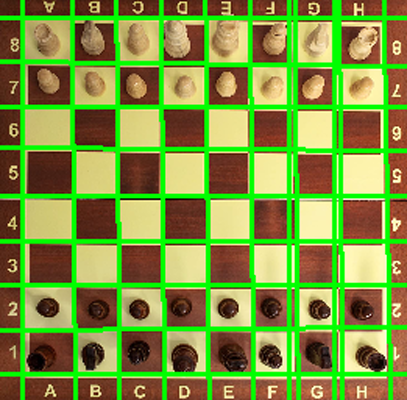

None

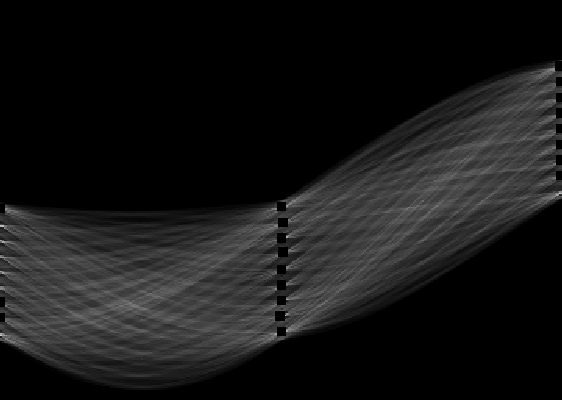

None

In [ ]:
def paint_lines(img, r, theta, is_radian = False):
  if not is_radian:
    theta = theta / 180 * np.pi
  if np.abs(np.sin(theta)) < 1e-15:
    start_point = (int(r), 0)
    end_point = (int(r), img.shape[0])
  else:
    start_point = (0, int((r - 0 * np.cos(theta)) / np.sin(theta)))
    end_point = (img.shape[1], int((r - img.shape[1] * np.cos(theta)) / np.sin(theta)))
  img = cv.line(img, start_point, end_point, (0, 255, 0), thickness=2)
  return img

def show_lines(img, ht):
  msize = 3
  diagonal = np.linalg.norm(img.shape[:2])
  for idx in range(num_lines):
    idx_r,idx_theta = np.unravel_index(ht.argmax(), ht.shape)
    theta = idx_theta / ht.shape[1] * 180
    r = idx_r / ht.shape[0] * 2 * diagonal - diagonal
    paint_lines(img, r, theta)
    ht[max(idx_r-msize,0):min(idx_r+msize,ht.shape[0]),\
            max(idx_theta-msize,0):min(idx_theta+msize,ht.shape[1])] = 0
    display.clear_output(wait=True)
    display.display(show(img, 400))
    display.display(show(ht, 400, interpolation=cv.INTER_NEAREST))
    time.sleep(1)

temp = img.copy()
ht_temp = ht.copy()
num_lines = 20
show_lines(temp, ht_temp)

Try doing the same for the rotated chessboard: **chessboard_rot.png**

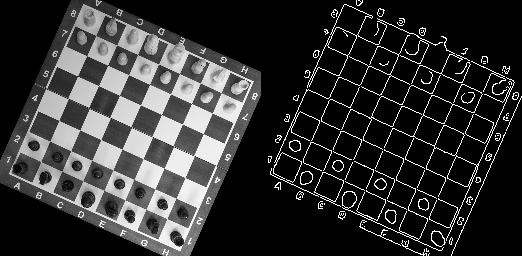

In [ ]:
img_rot = cv.imread('chessboard_rot.png')
img_rot = resize(img_rot, 256)
gray_rot = cv.cvtColor(img_rot, cv.COLOR_BGR2GRAY)
canny_rot = cv.Canny(gray_rot, 400, 600)
show_more(256, gray_rot, canny_rot)

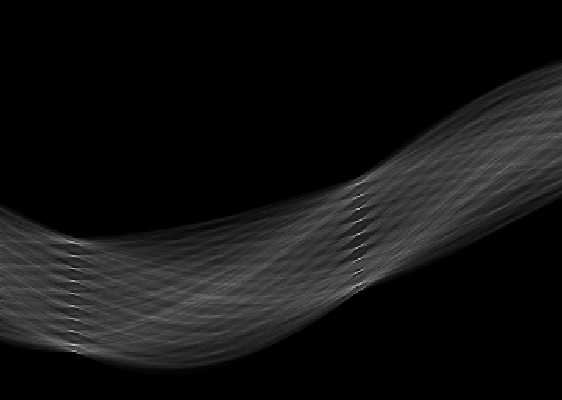

In [ ]:
ht_rot = hough(canny_rot,256,360)
show(ht_rot, 400, interpolation=cv.INTER_NEAREST)

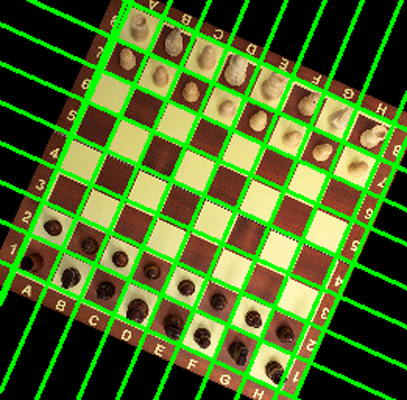

None

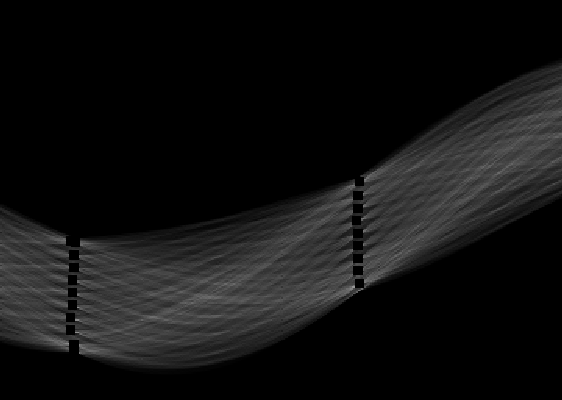

None

In [ ]:
temp = img_rot.copy()
ht_temp = ht_rot.copy()
num_lines = 20
show_lines(temp, ht_temp)

## Hough Tranform in OpenCV

**[`lines = cv.HoughLines()`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a)**

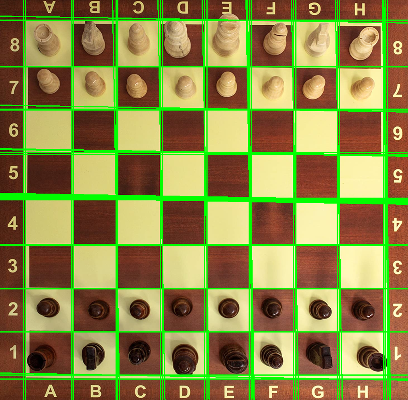

In [ ]:
img = cv.imread('chessboard.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray, 400, 600)

lines = cv.HoughLines(edges,1,np.pi/180,150)
for r, theta in lines[:,0]:
  img = paint_lines(img, r, theta, is_radian = True)

show(img,400)

### Randomized (Probabilistic) Hough Transform

Randomized Hough transform is different from HT in that it tries to avoid conducting the computationally expensive voting process for every nonzero pixel in the image by taking advantage of the geometric properties of analytical curves, and thus improve the time efficiency and reduce the storage requirement of the original algorithm.

**[`lines = cv.HoughLinesP()`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb)**

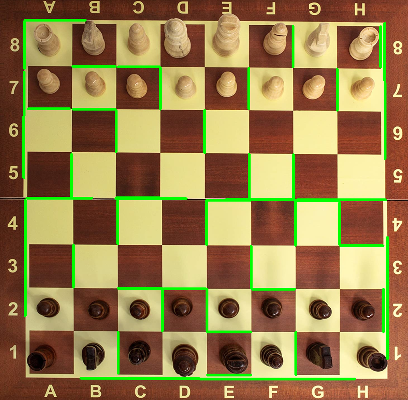

In [ ]:
img = cv.imread('chessboard.png')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray, 400, 600)

minLineLength = 10
maxLineGap = 100
lines = cv.HoughLinesP(edges,1,np.pi/180,10,minLineLength,maxLineGap)

for x1,y1,x2,y2 in lines[:,0]:
    cv.line(img,(x1,y1),(x2,y2),(0,255,0),5)

show(img,400)

## Hough Transform for an Analytic Curve

<img src="https://staff.utia.cas.cz/novozada/dizo/htparametric2.png">

### HT for circles
<img src="https://staff.utia.cas.cz/novozada/dizo/htdemo_circles.png">

Try to find circles in this image:
<img src="https://staff.utia.cas.cz/novozada/dizo/circle.jpg">

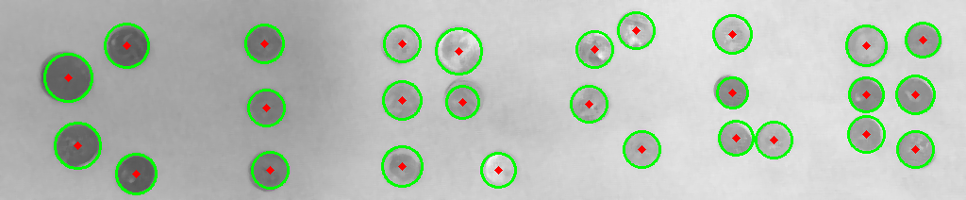

In [ ]:
img = cv.imread('circle.jpg',1)
img = img[:,:,2]
img = cv.medianBlur(img,5)
cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,minDist=20,
                            param1=50,param2=30,minRadius=5,maxRadius=50)

circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

show(cimg)

## Road Challenge - Lanes Detection

The number of vehicle owners is increasing and the cars with autonomous driving functions have attracted more and more attention. Let's try to write a simple lane detector based on HT.

Test image: **laneimage.jpg**

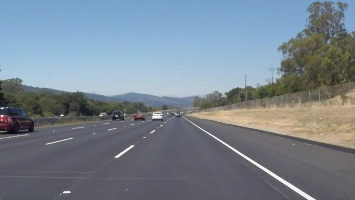

In [ ]:
img = cv.imread('laneimage.jpg')
show(img)

First we need to extract the edges, for example using a Canny detector.

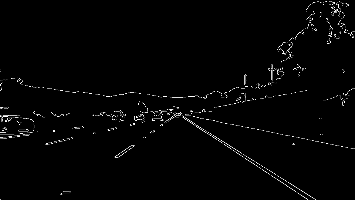

In [ ]:
def canny(image):
    gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    blur = cv.GaussianBlur(gray,(5, 5), 0)
    canny = cv.Canny(blur, 50, 150)
    return canny

img_lanes = np.copy(img)
edges = canny(img_lanes)
show(edges)

We're driving along the road, so we only need to look at a certain section of the image.

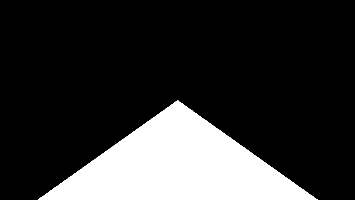

In [ ]:
height = edges.shape[0]
width = edges.shape[1]
polygons = np.array([[(100, height), (int(width/2), int(height/2)), (width-100, height)]])
mask = np.zeros_like(edges)
cv.fillPoly(mask, polygons, 255)
show(mask)

Now use this mask to mask out the edges.

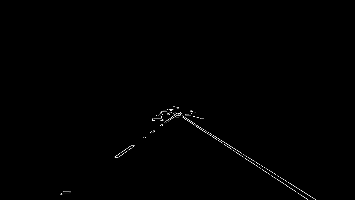

In [ ]:
def region_of_interest(image):
  height = edges.shape[0]
  width = edges.shape[1]
  polygons = np.array([[(100, height), (int(width/2), int(height/2)), (width-100, height)]])
  mask = np.zeros_like(edges)
  cv.fillPoly(mask, polygons, 255)
  img_mask = cv.bitwise_and(image, mask)
  return img_mask

edges_cropped = region_of_interest(edges)
show(edges_cropped)

When we have the candidate edges, we can detect the left and right lines.

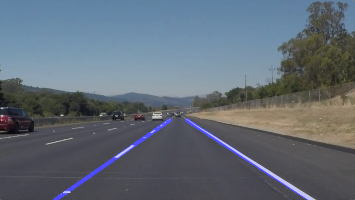

In [ ]:
# recalculating lines in an image
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1, y1, x2, y2])

# count average lines
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    return np.array([left_line, right_line])

# show the lines
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            cv.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

lines = cv.HoughLinesP(edges_cropped, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)

averaged_lines = average_slope_intercept(img, lines)
line_image = display_lines(img_lanes, averaged_lines)

combo_image = cv.addWeighted(img_lanes, 0.8, line_image, 1, 1)

show(combo_image)

Great. Let's try it on individual video frames.

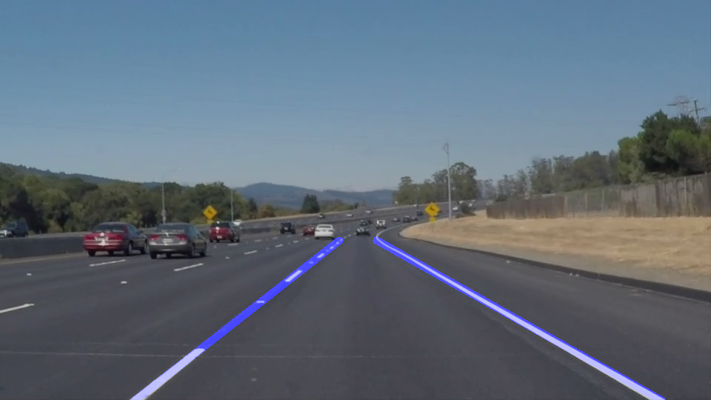

None

In [ ]:
vidIn = 'lanevideo.mp4'
cap = cv.VideoCapture(vidIn)
cc = 0
frame_step = 20

while cap.isOpened():
  ret, frame = cap.read()
  cc += 1
  if ret == True:
    if not np.mod(cc, frame_step):
      try:
        canny_image = canny(frame)
        cropped_image = region_of_interest(canny_image)
        lines = cv.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
        averaged_lines = average_slope_intercept(frame, lines)
        line_image = display_lines(frame, averaged_lines)
        combo_image = cv.addWeighted(frame, 0.8, line_image, 1, 1)
        display.clear_output(wait=True)
        display.display(show(combo_image, 400))
        time.sleep(1)
      except:
        print("not detected")
  else:
      break
cap.release()

# Part 2: Radon Transform

Theory is not taught in the lecture, so you can find it here:

[Everything you were afraid to ask about Radon Transform :)](https://staff.utia.cas.cz/novozada/dizo/RadonTransformPrezentace.pdf)

<img src="https://staff.utia.cas.cz/novozada/dizo/radon01.png">

 The inverse Radon transform is used in computed tomography to reconstruct a 2D image from the measured projections (the sinogram). A practical, exact implementation of the inverse Radon transform does not exist, but there are several good approximate algorithms available.

As the inverse Radon transform reconstructs the object from a set of projections, the (forward) Radon transform can be used to simulate a tomography experiment.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, iradon, iradon_sart
from skimage.transform.radon_transform import _get_fourier_filter

## The forward transform

<img src="https://staff.utia.cas.cz/novozada/dizo/fbp.png">

We will use the Shepp-Logan phantom.

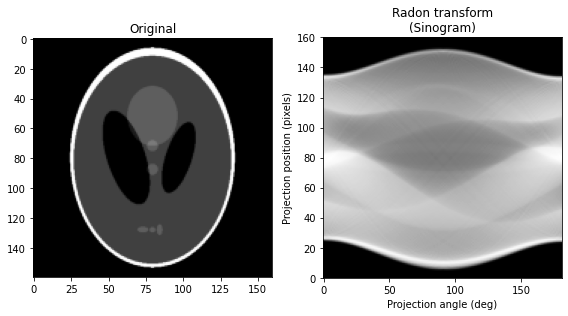

In [ ]:
image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

fig.tight_layout()
plt.show()

## Fourier Slice Theorem

<img src="https://staff.utia.cas.cz/novozada/dizo/fst.png">

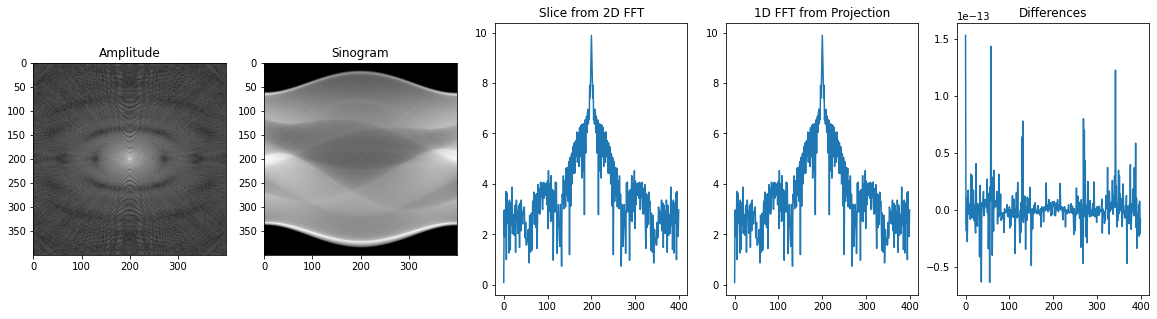

In [ ]:
image = shepp_logan_phantom()
fft2 = np.fft.fftshift(np.fft.fft2(image))
ampl2 = np.log(np.abs(fft2) + 1)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
sinogram_0 = sinogram[:, 0]
fft1 = np.fft.fftshift(np.fft.fft(sinogram_0))
ampl1 = np.log(np.abs(fft1) + 1)

plt.figure(figsize=(20, 5), constrained_layout=False)
plt.subplot(151)
plt.imshow(ampl2, "gray")
plt.title("Amplitude")
plt.subplot(152)
plt.imshow(sinogram, "gray")
plt.title("Sinogram")
plt.subplot(153)
plt.plot(ampl2[200,])
plt.title("Slice from 2D FFT")
plt.subplot(154)
plt.plot(ampl1)
plt.title("1D FFT from Projection")
plt.subplot(155)
plt.plot(ampl1-ampl2[200,])
plt.title("Differences")
plt.show()

## Reconstruction with the Filtered Back Projection (FBP)


<img src="https://staff.utia.cas.cz/novozada/dizo/fbp2f.png">

We use Fourier transform of the projection and interpolate it into the Fourier space to obtain the 2D Fourier transform of the image. Then we can inverte it to the reconstructed image. The only tunable parameter for the FBP is the filter, which is applied to the Fourier transformed projections. It may be used to suppress high frequency noise in the reconstruction - the common filters are:
*   `'ramp'`
*   `'shepp-logan'`
*   `'cosine'`
*   `'hamming'`
*   `'hann'`

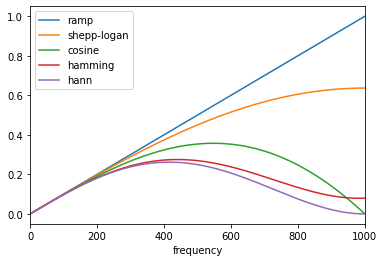

In [ ]:
filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

for ix, f in enumerate(filters):
      response = _get_fourier_filter(2000, f)
      plt.plot(response, label=f)

plt.xlim([0, 1000])
plt.xlabel('frequency')
plt.legend()
plt.show()

FBP rms reconstruction error: 0.0307


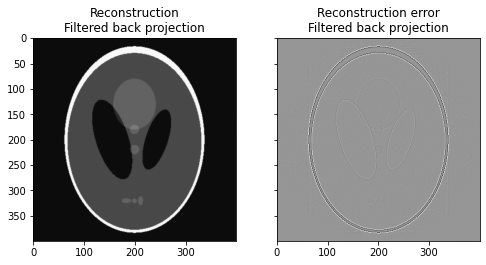

In [ ]:
theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

Use only every 10th projection for reconstruction.

FBP rms reconstruction error: 0.101


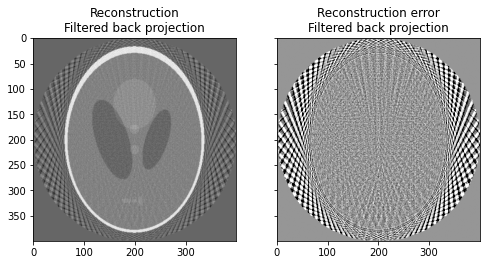

In [ ]:
use_each = 10
reconstruction_fbp = iradon(sinogram[:,::use_each], theta=theta[::use_each], filter_name='ramp')
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

# Part 3: Homework

## ✍🏼 Homework 004.1

Write a function **`angle_lines()`** that calculates the tilt of the lines in degrees from the image (tolerance 1 degree).

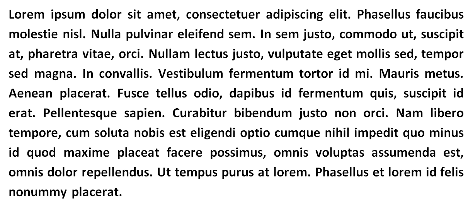

In [ ]:
img = cv.imread('text.png', cv.IMREAD_GRAYSCALE)
show(img)

def sh(img):
  cv2_imshow(img)

In [ ]:
img = cv.imread('text.png', cv.IMREAD_GRAYSCALE)

def angle_lines(img):
  angle = 0

  edges = cv.Canny(img, 100, 400)
  lines = cv.HoughLines(edges, 1, np.pi/180, 400)
  #pic = np.ones_like(img)*255
  if lines is not None:
    for r, theta in lines[:, 0]:
      #pic = paint_lines(pic, r, theta, is_radian=True)

      angle += 90 - (theta*180)/np.pi

  angle /= len(lines[:, 0])
  return angle

#Mean error of 0,55555 degree seems legit, right? Right..?

Test script:

In [ ]:
from IPython import display
from scipy import ndimage
angles = np.arange(-89, 89, 10)

angles_out = np.zeros(len(angles), dtype=np.int8)
for idx, angle in enumerate(angles):
  display.clear_output(wait=True)
  temp = ndimage.rotate(img, angle, cval=255)
  angles_out[idx] = angle_lines(temp)
  print(f'test angle = {angle} >> calculated angle = {angles_out[idx]}\n')

test_err = np.abs(angles - angles_out)
mean_err = np.mean(test_err)
print(f'Mean error = {mean_err}')

test angle = 81 >> calculated angle = 80

Mean error = 0.5555555555555556
